In [1]:
pip install matplotlib seaborn numpy plotly keras scikit-learn tensorflow nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install nbformat --upgrade

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [4]:
global_land_temperatures_by_country = pd.read_csv('climate_change/GlobalLandTemperaturesByCountry.csv')
global_temperatures = pd.read_csv('climate_change/GlobalTemperatures.csv')
global_temperatures_by_country = pd.read_csv('climate_change/GlobalLandTemperaturesByCountry.csv')

In [5]:
df = global_land_temperatures_by_country
df.head()


,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             577462 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  545550 non-null  float64
 3   Country                        577462 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.6+ MB


In [7]:
df.describe(include = 'all')

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
count,577462,544811.000000,545550.000000,577462
unique,3239,NaN,NaN,243
top,2013-09-01,NaN,NaN,Åland
freq,243,NaN,NaN,3239
mean,NaN,17.193354,1.019057,NaN
std,NaN,10.953966,1.201930,NaN
min,NaN,-37.658000,0.052000,NaN
25%,NaN,10.025000,0.323000,NaN
50%,NaN,20.901000,0.571000,NaN
75%,NaN,25.814000,1.206000,NaN


In [8]:
global_temperatures_by_country_clean = global_temperatures_by_country[~global_temperatures_by_country['Country'].isin(['Denmark', 'Antarctica', 'France', 'Europe', 'Netherlands', 'United Kingdom', 'Poland', 'Spain', 'Sweden', 'Norway', 'Germany', 'Europe', 'Russia', 'Turkey'])]

In [9]:
global_temperatures_by_country_clean = global_temperatures_by_country_clean.replace(
   ['Denmark (Europe)', 'France (Europe)', 'Netherlands (Europe)', 'United Kingdom (Europe)'],
   ['Denmark', 'France', 'Netherlands', 'United Kingdom'])

In [10]:
countries = np.unique(global_temperatures_by_country_clean['Country'])

mean_temp = []

for country in countries:
    mean_temp.append(global_temperatures_by_country_clean[global_temperatures_by_country_clean['Country'] == country]['AverageTemperature'].mean())

In [11]:
data = [ dict(
        type = 'choropleth',
        locations = countries,
        z = mean_temp,
        locationmode = 'country names',
        text = countries,
        marker = dict(
            line = dict(color = 'rgb(0,0,0)', width = 1)),
            colorbar = dict(autotick = True, tickprefix = '', 
            title = '# Average\nTemperature,\n°C')
            )
       ]

In [12]:
years = np.unique(global_temperatures_by_country_clean['dt'].apply(lambda x: x[:4]))

mean_temp_year_country = [ [0] * len(countries) for i in range(len(years[::10]))]

j = 0
for country in countries:
    all_temp_country = global_temperatures_by_country_clean[global_temperatures_by_country_clean['Country'] == country]
    i = 0
    for year in years[::10]:
        mean_temp_year_country[i][j] = all_temp_country[all_temp_country['dt'].apply(
                lambda x: x[:4]) == year]['AverageTemperature'].mean()
        i +=1
    j += 1

## Exploration and Visualization

### Country variable for further analysis

In [13]:
country = "Greenland"
df = global_temperatures_by_country[global_temperatures_by_country['Country']==country]
df.dropna(inplace=True)

In [14]:
import plotly.express as px

df['dt'] = pd.to_datetime(df['dt'])

fig = px.line(df, x='dt', y='AverageTemperature', title=f'Average Temperature in {country}')

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Average Temperature',
    xaxis=dict(rangeslider=dict(visible=True), type='date')
)

fig.show()


In [15]:
df['month'] = df['dt'].dt.month

monthly_avg_temp = df.groupby('month')['AverageTemperature'].mean().reset_index()

fig = go.Figure()

fig.add_trace(go.Scatter(x=monthly_avg_temp['month'], y=monthly_avg_temp['AverageTemperature'],
                         mode='lines+markers',
                         name='Average Temp',
                         hoverinfo='x+y'))

fig.update_layout(title=f'Average Monthly Temperature in {country}',
                  xaxis_title='Month',
                  yaxis_title='Average Temperature (°C)',
                  xaxis=dict(tickmode='array',
                             tickvals=monthly_avg_temp['month'],
                             ticktext=[str(i) for i in range(1, 13)]))

fig.show()


## Seasonal Temperatures

In [16]:
global_temperatures = global_temperatures[['dt', 'LandAverageTemperature']]

global_temperatures.loc[:,'dt'] = pd.to_datetime(global_temperatures['dt'])
global_temperatures.loc[:,'year'] = [x.year for x in list(global_temperatures['dt'])]
global_temperatures.loc[:,'month'] = [x.month for x in list(global_temperatures['dt'])]

def get_season(month):
    if month >= 3 and month <= 5:
        return 'spring'
    elif month >= 6 and month <= 8:
        return 'summer'
    elif month >= 9 and month <= 11:
        return 'autumn'
    else:
        return 'winter'
    
min_year = global_temperatures['year'].min()
max_year = global_temperatures['year'].max()
years = range(min_year, max_year + 1)

global_temperatures['season'] = global_temperatures['month'].apply(get_season)

sprint_temps = []
summer_temps = []
autumn_temps = []
winter_temps = []

for year in years:
    curr_years_data = global_temperatures[global_temperatures['year'] == year]
    sprint_temps.append(curr_years_data[curr_years_data['season'] == 'spring']['LandAverageTemperature'].mean())
    summer_temps.append(curr_years_data[curr_years_data['season'] == 'summer']['LandAverageTemperature'].mean())
    autumn_temps.append(curr_years_data[curr_years_data['season'] == 'autumn']['LandAverageTemperature'].mean())
    winter_temps.append(curr_years_data[curr_years_data['season'] == 'winter']['LandAverageTemperature'].mean())


In [17]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(years), y=summer_temps, mode='lines', name='Summers average temperature', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=list(years), y=autumn_temps, mode='lines', name='Autumns average temperature', line=dict(color='red')))
fig.add_trace(go.Scatter(x=list(years), y=sprint_temps, mode='lines', name='Springs average temperature', line=dict(color='green')))
fig.add_trace(go.Scatter(x=list(years), y=winter_temps, mode='lines', name='Winters average temperature', line=dict(color='blue')))

fig.update_layout(title=f'Average temperature of each season for {country}',
                  xaxis_title='Year',
                  yaxis_title='Average temperature',
                  legend=dict(x=1.02, y=0.5),
                  margin=dict(l=0, r=20, t=40, b=20),
                  hovermode='x unified')

fig.show()


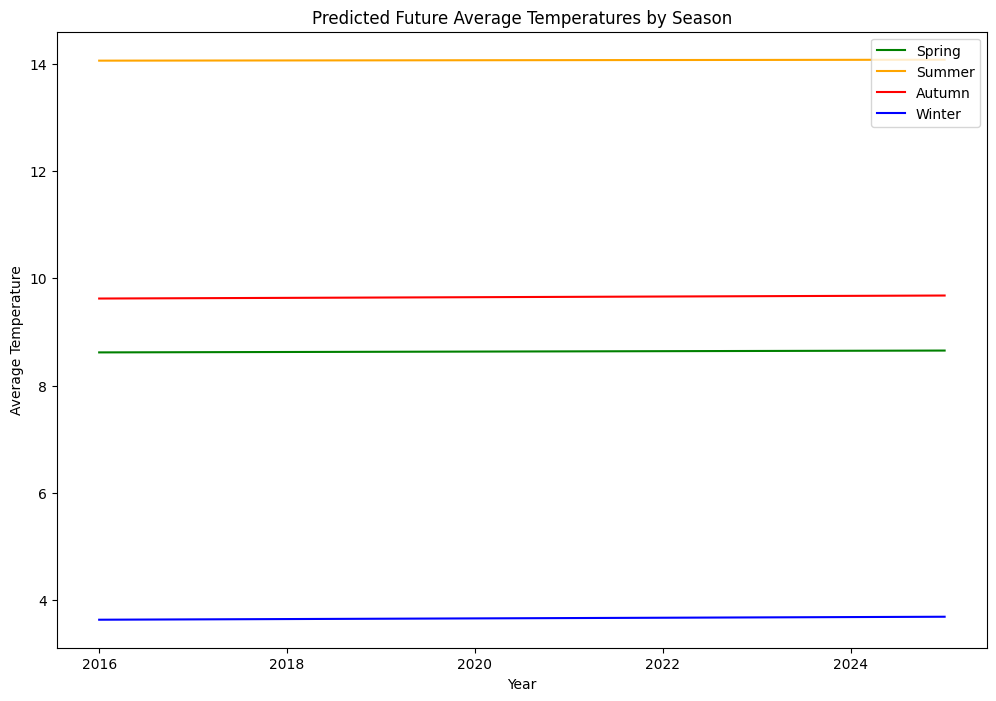

In [44]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Assuming `global_temperatures` and the seasonal temps are pandas Series or similar.
# Convert year to a DataFrame for compatibility with scikit-learn.
X = pd.DataFrame(global_temperatures['year'].unique(), columns=['year'])

# Prepare a dictionary of seasonal temperature data for iteration.
seasons_data = {
    'Spring': np.array(sprint_temps),
    'Summer': np.array(summer_temps),
    'Autumn': np.array(autumn_temps),
    'Winter': np.array(winter_temps)
}

# Colors for each season to improve graph aesthetics.
season_colors = {
    'Spring': 'g-',
    'Summer': 'orange',
    'Autumn': 'r-',
    'Winter': 'b-'
}

plt.figure(figsize=(12, 8))

for season, temps in seasons_data.items():
    Y = pd.DataFrame(temps, columns=[f'{season}_temps'])
    
    # Filter out entries with NaN values.
    valid_data = pd.concat([X, Y], axis=1).dropna()
    X_filtered = valid_data[['year']]
    Y_filtered = valid_data[f'{season}_temps']

    # Fit the model.
    model = LinearRegression().fit(X_filtered, Y_filtered.values.reshape(-1, 1))

    # Prepare future predictions.
    future_years = pd.DataFrame(range(X_filtered['year'].max() + 1, X_filtered['year'].max() + 11), columns=['year'])
    predictions = model.predict(future_years)

    # Plot predictions.
    plt.plot(future_years, predictions, season_colors[season], label=season)

plt.title('Predicted Future Average Temperatures by Season')
plt.xlabel('Year')
plt.ylabel('Average Temperature')
plt.legend()
plt.show()


## Average Land Temperature by Country

In [19]:
global_temperature_temp = pd.read_csv('climate_change/GlobalLandTemperaturesByCountry.csv')

In [39]:
years = np.unique(global_temperature_temp['dt'].apply(lambda x: x[:4]))
mean_temp_country = []
mean_temp_country_uncertainty = []

for year in years:
    mean_temp_country.append(global_temperature_temp[global_temperature_temp['dt'].apply(lambda x: x[:4]) == year]['AverageTemperature'].mean())
    mean_temp_country_uncertainty.append(global_temperature_temp[global_temperature_temp['dt'].apply(lambda x: x[:4]) == year]['AverageTemperatureUncertainty'].mean())

trace0 = go.Scatter(
    x = years,
    y = np.array(mean_temp_country) + np.array(mean_temp_country_uncertainty),
    fill = None,
    mode = 'lines',
    name = 'Uncertainty top value',
    line = dict(
        color = 'rgb(0, 255, 255)',
    )
)

trace1 = go.Scatter(
    x = years, 
    y = np.array(mean_temp_country) - np.array(mean_temp_country_uncertainty),
    fill='tonexty',
    mode='lines',
    name='Uncertainty bottom value',
    line=dict(
        color='rgb(0, 255, 255)',
    )
)

trace2 = go.Scatter(
    x = years,
    y = mean_temp_country,
    fill=None,
    mode='lines',
    name='Average temperature',
    line=dict(
        color='rgb(199, 121, 093)',
    )
)

data = [trace0, trace1, trace2]

layout = go.Layout(
    title='Average temperature with uncertainty interval',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Average Temperature, °C'),
    showlegend = True
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

**Note:** The code below is outdated and no longer valid. Please disregard it.

